## requirements
* tensorflow
* adjustText (pip install adjustText)

In [1]:
%load_ext tensorboard

In [617]:
import pandas as pd
import os
import numpy as np
from tqdm.notebook import tqdm
import faiss
import h5py, torch
from torchbiggraph.model import ComplexDiagonalDynamicOperator, DotComparator, CosComparator
import json
from utility import kgtk_to_dataframe
from scipy.spatial import distance
from sklearn.metrics.pairwise import cosine_similarity
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorboard.plugins import projector
from adjustText import adjust_text
import glob
import itertools
from collections import Counter, defaultdict
from functools import reduce

In [3]:
work_dir = "./output/wikidata-20210215-dwd"
store_dir = "./output/wikidata-20210215-dwd/temp-surprise"
# item_file = "./data/wikidata-20210215-dwd/claims.wikibase-item.tsv.gz"
label_file = "./data/wikidata-20210215-dwd/labels.en.tsv.gz"
# pagerank_file = "./data/wikidata-20210215-dwd/metadata.pagerank.directed.tsv.gz"
descriptions_file = "./data/wikidata-20210215-dwd/descriptions.en.tsv.gz"

# embedding_files = {
#                    "Profile-ComplEx" : "./output/wikidata-20210215-dwd/profile_graph_embeddings/profile_graph_embeddings.ComplEx.tsv",
#                    "Profile-TransE" : "./output/wikidata-20210215-dwd/profile_graph_embeddings/profile_graph_embeddings.TransE.tsv"
#                   }

complex_dir = "/data02/profiling/wikidata-20210215-dwd-v2.complex-embeddings"
vector_dimension = 100

complex_faiss_file = "/data02/profiling/complex_embeddings/wikidataos.v2.20211114.complex.index.idx"
complex_faiss_id2node_file = "/data02/profiling/complex_embeddings/wikidataos.v2.20211114.complex.index_to_qnode.test.tsv"

### Process params / set up variables

In [4]:
# Ensure paths are absolute
work_dir = os.path.abspath(work_dir)
# store_dir = os.path.abspath(store_dir)
# item_file = os.path.abspath(item_file)
label_file = os.path.abspath(label_file)
descriptions_file = os.path.abspath(descriptions_file)
# for name, file_path in embedding_files.items():
#     embedding_files[name] = os.path.abspath(file_path)

# profile_graph_dir = "{}/label_formatting".format(work_dir)
    
# Create directories
output_dir = "{}/surprise_prediction".format(work_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
if not os.path.exists(store_dir):
    os.makedirs(store_dir)
    
# adding some environment variables we'll be using frequently
os.environ['STORE'] = "{}/wikidata.sqlite3.db".format(store_dir)
# os.environ['OUT'] = output_dir
# os.environ['PGRAPH'] = profile_graph_dir
os.environ['LABELS'] = label_file

### Load various things: profile labels, english labels, descriptions, embeddings

Load profile labels (reusing some work already done by another notebook here -- fun_fact_exploration)

In [5]:
profile_labels_df = pd.read_csv(f"{work_dir}/explainability/profile_labels_info_joined.RELs_and_AILs.tsv", sep='\t', dtype=str).fillna("")

In [6]:
label_distinctiveness_df = pd.read_csv(f"{work_dir}/explainability/profile_labels.RELs_and_AILs.distinctiveness.tsv", sep='\t')
label_distinctiveness_dict = dict(zip(label_distinctiveness_df.node1, label_distinctiveness_df.node2))

distinctivenesses = []
for _, row in tqdm(profile_labels_df.iterrows(), total=len(profile_labels_df)):
    label = row["id"]
    distinctivenesses.append(label_distinctiveness_dict[label])
profile_labels_df["distinctiveness"] = distinctivenesses

  0%|          | 0/621114 [00:00<?, ?it/s]

In [7]:
labels_en_df = pd.read_csv(label_file, sep='\t')

In [8]:
labels_en_dict = dict(zip(labels_en_df.node1, labels_en_df.node2))

In [9]:
descriptions_df = pd.read_csv(descriptions_file, sep='\t')

In [10]:
descriptions_dict = dict(zip(descriptions_df.node1, descriptions_df.node2))

In [11]:
def remove_lang_tag(label):
    return label[1:-4]

In [ ]:
# Note this code assumes we are only using AILs and RELs
plab_labels = []
for _, row in tqdm(profile_labels_df.iterrows(), total=len(profile_labels_df)):
    type_label = remove_lang_tag(row["type_label"])
    property_label = remove_lang_tag(row["property_label"])
    if row["node2"] != "":
        if row["node2"] in labels_en_dict:
            value_label = remove_lang_tag(labels_en_dict[row["node2"]])
        else:
            value_label = row["node2"]
    else:
        lb = row["lower_bound"]
        ub = row["upper_bound"]
        value_label = f"{lb}-{ub}"
        si = row["si_units"]
        wd = row["wd_units"]
        if wd != "":
            if wd in labels_en_dict:
                wd = remove_lang_tag(labels_en_dict[wd])
            value_label = value_label + f" {wd}"
        elif si != "":
            value_label = value_label + f" {si}"
    plab_labels.append(f"{type_label}, {property_label}, {value_label}")
profile_labels_df["plab_label"] = plab_labels

In [ ]:
# Trim profile_labels_df to just columns we need
profile_labels_df = profile_labels_df.loc[:,["id", "plab_label", "support", "distinctiveness"]]

set up dictionaries for profile-label to entities and vice-versa to speed things up.

In [15]:
%%time
entity_prof_labels_df = pd.read_csv(f"{work_dir}/explainability/entity_profile_labels.RELs_and_AILs.shuffled.tsv", sep='\t')


CPU times: user 2min 2s, sys: 23.6 s, total: 2min 25s
Wall time: 2min 27s


In [17]:
%time ent_to_labels_dict = entity_prof_labels_df.groupby('node1')['node2'].apply(list).to_dict()

CPU times: user 10min 39s, sys: 39.7 s, total: 11min 19s
Wall time: 11min 18s


In [19]:
%time label_to_ents_dict = entity_prof_labels_df.groupby('node2')['node1'].apply(list).to_dict()

CPU times: user 1min 25s, sys: 7.19 s, total: 1min 32s
Wall time: 1min 32s


In [20]:
del entity_prof_labels_df

#### Load embeddings

In [21]:
embedding_models = {}

complex

In [22]:
print("loading entity names list...")
entity_names_list = json.load(open(f"{complex_dir}/entity_names_all_0.json"))

# Load the embeddings
print("loading all embeddings...")
with h5py.File(f"{complex_dir}/model/embeddings_all_0.v600.h5", "r") as hf:
    embeddings = hf["embeddings"][...]

print("creating complex embedding dict...")
complex_embs={}
for i in tqdm(range(len(entity_names_list))):
    complex_embs[entity_names_list[i]] = embeddings[i]

loading entity names list...
loading all embeddings...
creating complex embedding dict...


  0%|          | 0/53002670 [00:01<?, ?it/s]

In [23]:
embedding_models["complex"] = complex_embs

PCA text embeddings

In [24]:
pca_text_emb_file = "/data02/profiling/dwd-v3.text-embeddings.PCA100/faiss_index/kgtk_text_embeddings_all.PCA100.tsv"
text_emb_df = pd.read_csv(pca_text_emb_file, sep='\t')
text_emb_dict = {}
for _, row in tqdm(text_emb_df.iterrows()):
    ent = row["node1"]
    embed = np.float32(row["node2"].split(','))
    text_emb_dict[ent] = embed

0it [00:00, ?it/s]

In [25]:
embedding_models["pca100_text"] = text_emb_dict

Original text embeddings (subset)

In [26]:
orig_embed_subsets_dir = "/data02/profiling/dwd-v3.class_subsets"

In [27]:
orig_embed_dict = {}
for filename in glob.glob(f"{orig_embed_subsets_dir}/*"):
    print(f"loading from file {filename}")
    embedding_df = pd.read_csv(filename, sep='\t')
    for _, row in tqdm(embedding_df.iterrows()):
        ent = row["node1"]
        embed = np.float32(row["node2"].split(','))
        orig_embed_dict[ent] = embed

loading from file /data02/profiling/dwd-v3.class_subsets/Q5.tsv.gz


0it [00:00, ?it/s]

loading from file /data02/profiling/dwd-v3.class_subsets/Q3624078.tsv.gz


0it [00:00, ?it/s]

loading from file /data02/profiling/dwd-v3.class_subsets/Q532.tsv.gz


0it [00:00, ?it/s]

loading from file /data02/profiling/dwd-v3.class_subsets/Q23442.tsv.gz


0it [00:00, ?it/s]

loading from file /data02/profiling/dwd-v3.class_subsets/Q783794.tsv.gz


0it [00:00, ?it/s]

loading from file /data02/profiling/dwd-v3.class_subsets/Q3305213.tsv.gz


0it [00:00, ?it/s]

loading from file /data02/profiling/dwd-v3.class_subsets/Q11424.tsv.gz


0it [00:00, ?it/s]

loading from file /data02/profiling/dwd-v3.class_subsets/Q7725634.tsv.gz


0it [00:00, ?it/s]

loading from file /data02/profiling/dwd-v3.class_subsets/Q571.tsv.gz


0it [00:00, ?it/s]

loading from file /data02/profiling/dwd-v3.class_subsets/Q47461344.tsv.gz


0it [00:00, ?it/s]

loading from file /data02/profiling/dwd-v3.class_subsets/Q4830453.tsv.gz


0it [00:00, ?it/s]

In [28]:
embedding_models["text1024"] = orig_embed_dict

## Methods for computing measure of surprise

Shuffle entity-labels table so we can randomly sample

In [134]:
%%time
df = pd.read_csv(f"{work_dir}/explainability/entity_profile_labels.RELs_and_AILs.tsv", sep='\t', dtype=str).fillna("")
df = df.sample(frac=1).reset_index(drop=True)

CPU times: user 2min 43s, sys: 26.6 s, total: 3min 9s
Wall time: 3min 9s


In [135]:
df.head()

,node1,label,node2,id
0,Q19081699,P31_profile,Q2334719_P31_Q19692072,E13647036
1,Q64186296,P1436_profile,Q2668072_P1436_0.0-0.0__Q11723795,E69951718
2,Q80894539,P59_profile,Q2154519_P59_Q8910,E56344602
3,Q422894,P131_profile,Q3700011_P131_Q10365,E30885868
4,Q6236968,P735_profile,Q5_P735_Q4925477,E42678981


In [136]:
df.to_csv(f"{work_dir}/explainability/entity_profile_labels.RELs_and_AILs.shuffled.tsv", sep='\t', index=False)

In [632]:
def get_entity_profile_labels_set(ent, ent_to_labels_dict=None):
    if ent_to_labels_dict is not None and ent in ent_to_labels_dict:
        return set(ent_to_labels_dict[ent])
    res = !kgtk query -i {work_dir}/explainability/entity_profile_labels.RELs_and_AILs.shuffled.tsv --graph-cache $STORE \
          --match 'profile_labels: (ent)-[]->(profile_label_id)' \
          --return 'distinct profile_label_id' \
          --where 'ent = "{ent}"'
    return set(kgtk_to_dataframe(res).loc[:,"node2"])
    
def get_entity_profile_labels_df(profile_labels_df, ent, ent_to_labels_dict=None):
    labels = get_entity_profile_labels_set(ent, ent_to_labels_dict)
    return profile_labels_df.loc[profile_labels_df.loc[:,"id"].isin(labels),:]

def get_entities_with_profile_label(label_id, ent_to_omit=None, limit=1000, label_to_ents_dict=None):
    if label_to_ents_dict is not None and label_id in label_to_ents_dict:
        ents = list(label_to_ents_dict[label_id])
        if ent_to_omit is not None and ent_to_omit in ents:
            ents.remove(ent_to_omit)
        return set(np.random.choice(ents, min(len(ents),limit), replace=False))
    res = !kgtk query -i {work_dir}/explainability/entity_profile_labels.RELs_and_AILs.shuffled.tsv --graph-cache $STORE \
        --match 'profile_labels: (ent)-[]->(profile_label_id)' \
        --return 'distinct ent' \
        --where 'ent != "{ent_to_omit}" AND profile_label_id = "{label_id}"' \
        --limit {limit}
    return set(kgtk_to_dataframe(res).loc[:,"node1"])

def get_embeds(ents):
    return embeddings[[entity_to_index[ent] for ent in ents], :].detach().numpy()

def get_ents_of_type(ent_to_omit, ent_type, limit=1000):
    res = !kgtk query -i {work_dir}/explainability/entity_profile_labels.RELs_and_AILs.shuffled.tsv --graph-cache $STORE \
        --match 'profile_labels: (ent)-[]->(profile_label_id)' \
        --return 'distinct ent' \
        --where 'ent != "{ent_to_omit}" AND printf("%.{len(ent_type)}s", profile_label_id) = "{ent_type}"' \
        --limit {limit}
    return set(kgtk_to_dataframe(res).loc[:,"node1"])

def compute_surprise_metrics_for_sample(ent, sample_ents, embedding_dict, pairwise_sample=10000):
    ret = {}
    
    # get embeddings
    sample_embeds = np.array([embedding_dict[s] for s in sample_ents if s in embedding_dict])
    ent_embed = embedding_dict[ent]

    # centroid-based measures
    centroid = np.mean(sample_embeds, axis=0)
    dists = np.array([distance.cosine(centroid, e) for e in sample_embeds])
    avg_sample_to_centroid = np.mean(dists)
    ret["dispersion (centroid)"] = avg_sample_to_centroid
    ent_to_centroid = distance.cosine(centroid, ent_embed)
    ret["distance (centroid)"] = ent_to_centroid
    ret["distance(centroid)/dispersion(centroid)"] = ent_to_centroid / avg_sample_to_centroid

    # avg sample dist to entity of interest
    ent_dists = np.array([distance.cosine(ent_embed, e) for e in sample_embeds])
    avg_ent_to_sample = np.mean(ent_dists)
    ret["distance (avg pairwise)"] = avg_ent_to_sample
    ret["distance(avg pairwise)/dispersion(centroid)"] = avg_ent_to_sample / avg_sample_to_centroid

    # avg pairwise dist within sample
    sample_dists = []
    for i in range(pairwise_sample):
        e1, e2 = sample_embeds[np.random.choice(sample_embeds.shape[0], size=2, replace=False), :]
#         e1, e2 = random.sample(list(sample_embeds), 2) # Slower
        sample_dists.append(distance.cosine(e1, e2))
    avg_sample_to_sample = np.mean(sample_dists)
    ret["dispersion (avg pairwise)"] = avg_sample_to_sample
    ret["distance(avg pairwise)/dispersion(avg pairwise)"] = avg_ent_to_sample / avg_sample_to_sample
        
    return ret

def compute_avg_pairwise_dist_in_sample(sample_ents, embedding_dict, pariwise_sample=10000):
    # get embeddings
    sample_embeds = np.array([embedding_dict[s] for s in sample_ents if s in embedding_dict])
    # avg pairwise dist within sample
    sample_dists = []
    for i in range(pairwise_sample):
        e1, e2 = sample_embeds[np.random.choice(sample_embeds.shape[0], size=2, replace=False), :]
#         e1, e2 = random.sample(list(sample_embeds), 2) # Slower
        sample_dists.append(distance.cosine(e1, e2))
    avg_sample_to_sample = np.mean(sample_dists)
    return avg_sample_to_sample

def compute_avg_dist_from_ent_to_sample(ent, sample_ents, embedding_dict):
    # get embeddings
    ent_embed = embedding_dict[ent]
    sample_embeds = np.array([embedding_dict[s] for s in sample_ents if s in embedding_dict])
    # avg sample dist to entity of interest
    ent_dists = np.array([distance.cosine(ent_embed, e) for e in sample_embeds])
    avg_ent_to_sample = np.mean(ent_dists)
    return avg_ent_to_sample

def compute_surprise_metrics_for_ent_fact(ent, fact_ids, embedding_models, label_to_ents_dict=None, sample=10000, pairwise_sample=10000):
    # fact_ids are used to form the sample by taking union of samples for each fact
    ents_sharing_label = set()
    for fact in fact_ids:
        ents_sharing_label = ents_sharing_label | get_entities_with_profile_label(fact, ent, sample, label_to_ents_dict)
    
    metrics_dict = {}
    for name, embedding_dict in embedding_models.items():
        label_metrics = compute_surprise_metrics_for_sample(ent, ents_sharing_label, embedding_dict, pairwise_sample)
        metrics_dict[name] = label_metrics
        
    return metrics_dict

def compute_surprise_metrics_for_df(ent, facts_df, embedding_models, label_to_ents_dict=None, sample=10000, pairwise_sample=10000):
    label_ids = facts_df.loc[:,"id"]
    
    # for each profile label, sample entities and compute surprise metrics with each embedding model
    metrics_dict = {}
    for label_id in tqdm(label_ids):
        ents_sharing_label = get_entities_with_profile_label(label_id, ent, sample, label_to_ents_dict)
        for name, embedding_dict in embedding_models.items():
            label_metrics = compute_surprise_metrics_for_sample(ent, ents_sharing_label, embedding_dict, pairwise_sample)
            for k, v in label_metrics.items():
                emb_specific_key = f"{k} - {name}"
                if emb_specific_key not in metrics_dict:
                    metrics_dict[emb_specific_key] = []
                metrics_dict[emb_specific_key].append(v)
        
    for k, v in metrics_dict.items():
        facts_df.loc[:,k] = v
    
    return facts_df

def compute_surprise_metrics_sampling_by_type(ent, ent_type, embedding_dict, sample=10000, pairwise_sample=10000):
    ents_sharing_type = get_ents_of_type(ent, ent_type, sample)
    return compute_surprise_metrics_for_sample(ent, ents_sharing_type, embedding_dict, pairwise_sample)

# plotting function
def plot_surprise_metrics(df, x_col, y_col, label_col, size_col, color_col=None):
    df = df.sort_values(size_col, ascending=False)
    labels = list(df.loc[:, label_col])
    x = list(df.loc[:, x_col])
    y = list(df.loc[:, y_col])
    size = np.array(df.loc[:, size_col])
    if color_col is not None:
        color = np.array(df.loc[:, color_col])
        color_dict={0: "grey", 1: "yellow", 2: "green"}
        color = [color_dict[c] for c in color]
    # rescaling
    size -= np.min(size)
    size *= (150 / np.max(size))
    size += 10
    
    fig, ax = plt.subplots()
    for i in range(len(x)):
        c = color[i] if color is not None else None
        ax.scatter(x[i], y[i], c=c, s=size[i], label=labels[i])
    
    texts = [plt.text(x[i], y[i], labels[i].split(", ")[-1]) for i in range(len(x))]
    adjust_text(texts, x=x, y=y)
#     for i, txt in enumerate(labels):
#         ax.annotate(txt, (x[i], y[i]))
    
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_ylabel(y_col)
    ax.set_xlabel(x_col)
    ax.set_title(size_col)
    ax.grid(True)
    
    fig.set_figwidth(8)
    fig.set_figheight(8)

    plt.show()

## Load MC quiz data

In [554]:
url = "https://docs.google.com/spreadsheets/d/1JNtLiQyLwuYOi2t14nYbaZAhneuRuGQGfmIJJY2WKlE/export?format=csv&gid=590588681"
df = pd.read_csv(url, dtype=str)

In [560]:
questions = [
        {
            "lexicalized" : "What language(s) does Vladimir Putin speak, write, or sign with?",
            "entity": "Q7747",
            "class" : "Q5",
            "prop" : "P1412",
            "wd_units" : None,
            "ans_to_qnode" : {"English": "Q1860",
                              "German": "Q188",
                              "Russian": "Q7737",
                              "Swedish": "Q9027",
                              "Spanish": "Q1321"},
            "gt_wd" : {"Russian", "English", "German", "Swedish"},
            "gt_irl" : {"Russian", "English", "German", "Swedish"},
            "single_answer" : False
        },
        {
            "lexicalized" : "What occupation(s) has John Oliver had?",
            "entity": "Q1701254",
            "class" : "Q5",
            "prop" : "P106",
            "wd_units" : None,
            "ans_to_qnode" : {"Film Actor": "Q10800557",
                              "Writer": "Q36180",
                              "Television Actor": "Q10798782",
                              "Television Presenter": "Q947873",
                              "Film Producer": "Q3282637"
                             },
            "gt_wd" : {"Film Actor", "Television Actor", "Writer", "Television Presenter"},
            "gt_irl" : {"Film Actor", "Television Actor", "Writer", "Television Presenter"},
            "single_answer" : False
        },
        {
            "lexicalized" : "Please select the country or countries in which Roger Federer possesses citizenship",
            "entity": "Q1426",
            "class" : "Q5",
            "prop" : "P27",
            "wd_units" : None,
            "ans_to_qnode" : {'South Africa': "Q258",
                              'Switzerland': "Q39",
                              'South Korea': "Q884",
                              'France': "Q142",
                              'United States of America': "Q30"
                             },
            "gt_wd" : {"South Africa", "Switzerland"},
            "gt_irl" : {"South Africa", "Switzerland"},
            "single_answer" : False
        },
        {
            "lexicalized" : "How many children does Arnold Schwarzenegger have?",
            "entity": "Q2685",
            "class" : "Q5",
            "prop" : "P1971",
            "wd_units" : "",
            "ans_to_qnode" : {"2 or fewer": "0.0-2.0",
                              "3":"2.0-3.0",
                              "4":"3.0-4.0",
                              "5 or more": "4.0-210.0"
                             },
            "gt_wd" : {"5 or more"},
            "gt_irl" : {"5 or more"},
            "single_answer" : True
        },
        {
            "lexicalized" : "What is Boris Johnson's place of birth?",
            "entity": "Q180589",
            "class" : "Q5",
            "prop" : "P19",
            "wd_units" : None,
            "ans_to_qnode" : {"New York City": "Q60",
                              "Paris": "Q90",
                              'Rome': "Q220",
                              'Hamburg': "Q1055",
                              'London': "Q84"},
            "gt_wd" : {"New York City"},
            "gt_irl" : {"New York City"},
            "single_answer" : True
        },
        {
            "lexicalized" : "What occupation(s) has Eminem had?",
            "entity": "Q5608",
            "class" : "Q5",
            "prop" : "P106",
            "wd_units" : None,
            "ans_to_qnode" : {'Author': "Q482980",
                              'Film Producer': "Q3282637",
                              'Entrepreneur': "Q131524",
                              'Singer-songwriter': "Q488205",
                              'Painter': "Q1028181"},
            "gt_wd" : {"Author", "Film Producer", "Singer-songwriter", "Entrepreneur"},
            "gt_irl" : {"Author", "Film Producer", "Singer-songwriter", "Entrepreneur"},
            "single_answer" : False
        },
        {
            "lexicalized" : "What occupation(s) has George W. Bush had?",
            "entity": "Q207",
            "class" : "Q5",
            "prop" : "P106",
            "wd_units" : None,
            "ans_to_qnode" : {'Rugby Union Player': "Q14089670",
                              'Politician': "Q82955",
                              'Military Officer': "Q189290",
                              'Painter': "Q1028181",
                              'Singer': "Q177220"
                             },
            "gt_wd" : {"Rugby Union Player", "Politician", "Military Officer", "Painter"},
            "gt_irl" : {"Rugby Union Player", "Politician", "Military Officer", "Painter"},
            "single_answer" : False
        },
        {
            "lexicalized" : "What occupation(s) has Beyoncé had?",
            "entity": "Q36153",
            "class" : "Q5",
            "prop" : "P106",
            "wd_units" : None,
            "ans_to_qnode" : {'Model': "Q4610556",
                              'Voice Actor': "Q2405480",
                              'Entrepreneur': "Q131524",
                              'Singer-songwriter': "Q488205",
                              'Dancer': "Q5716684"},
            "gt_wd" : {"Model", "Voice Actor", "Singer-songwriter", "Entrepreneur", "Dancer"},
            "gt_irl" : {"Model", "Voice Actor", "Singer-songwriter", "Entrepreneur", "Dancer"},
            "single_answer" : False
        },
        {
            "lexicalized" : "What is Donald Trump's mass in pounds circa. 2019?",
            "entity": "Q22686",
            "class" : "Q5",
            "prop" : "P2067",
            "wd_units" : "Q100995",
            "ans_to_qnode" : {"> 1 and <= 181": "1.0-181.0",
                              "> 181 and <= 195": "181.0-195.0",
                              "> 195 and <= 210": "195.0-210.0",
                              "> 210 and <= 240": "210.0-240.0",
                              "> 240": "240.0-555.0",
                             },
            "gt_wd" : {"> 240"},
            "gt_irl" : {"> 240"},
            "single_answer" : True
        },
        {
            "lexicalized" : "What political party/parties has Donald Trump been a member of?",
            "entity": "Q22686",
            "class" : "Q5",
            "prop" : "P102",
            "wd_units" : None,
            "ans_to_qnode" : {'Democratic Party': "Q29552",
                              'Republican Party': "Q29468",
                              'Communist Party of the Soviet Union': "Q79854",
                              'National Socialist German Workers\' Party': "Q7320",
                              'Social Democratic Party of Germany': "Q49768"
                             },
            "gt_wd" : {"Democratic Party", "Republican Party"},
            "gt_irl" : {"Democratic Party", "Republican Party"},
            "single_answer" : False
        },
        {
            "lexicalized" : "What occupation(s) has John Cena had?",
            "entity": "Q44437",
            "class" : "Q5",
            "prop" : "P106",
            "wd_units" : None,
            "ans_to_qnode" : {'Musician': "Q639669",
                              'Voice Actor': "Q2405480",
                              'Writer': "Q36180",
                              'Politician': "Q82955",
                              'Chess Player': "Q10873124"},
            "gt_wd" : {"Musician", "Voice Actor", "Writer"},
            "gt_irl" : {"Musician", "Voice Actor", "Writer"},
            "single_answer" : False
        },
        {
            "lexicalized" : "What sport(s) has John Cena participated in?",
            "entity": "Q44437",
            "class" : "Q5",
            "prop" : "P641",
            "wd_units" : None,
            "ans_to_qnode" : {'American Football': "Q41323",
                              'Baseball': "Q5369",
                              'Amateur Wrestling': "Q838089",
                              'Boxing': "Q32112",
                              'Rugby': "Q5378",
                             },
            "gt_wd" : {"American Football"},
            "gt_irl" : {"American Football"},
            "single_answer" : False
        },
        {
            "lexicalized" : "What occupation(s) has Kanye West had?",
            "entity": "Q15935",
            "class" : "Q5",
            "prop" : "P106",
            "wd_units" : None,
            "ans_to_qnode" : {'Architect': "Q42973",
                              'Film Director': "Q2526255",
                              'Politician': "Q82955",
                              'Singer': "Q177220",
                              'Sport Cyclist': "Q2309784"},
            "gt_wd" : {"Film Director", "Politician", "Singer", "Architect"},
            "gt_irl" : {"Film Director", "Politician", "Singer"},
            "single_answer" : False
        },
        {
            "lexicalized" : "What occupation(s) has LeBron James had?",
            "entity": "Q36159",
            "class" : "Q5",
            "prop" : "P106",
            "wd_units" : None,
            "ans_to_qnode" : {'Television Actor': "Q10798782",
                              'Basketball Player': "Q3665646",
                              'Screenwriter': "Q28389",
                              'Researcher': "Q1650915",
                              'Writer': "Q36180"
                             },
            "gt_wd" : {"Television Actor", "Basketball Player", "Screenwriter"},
            "gt_irl" : {"Television Actor", "Basketball Player", "Screenwriter", "Writer"},
            "single_answer" : False
        },
        {
            "lexicalized" : "What occupation(s) did Leonardo Da Vinci have?",
            "entity": "Q762",
            "class" : "Q5",
            "prop" : "P106",
            "wd_units" : None,
            "ans_to_qnode" : {'Diplomat': "Q193391",
                              'Zoologist': "Q350979",
                              'Chemist': "Q593644",
                              'Painter': "Q1028181",
                              'Engineer': "Q81096"
                             },
            "gt_wd" : {"Zoologist", "Chemist", "Painter", "Engineer", "Diplomat"},
            "gt_irl" : {"Zoologist", "Chemist", "Painter", "Engineer"},
            "single_answer" : False
        },
        {
            "lexicalized" : "What language(s) did Ruth Bader Ginsburg speak, write, or sign?",
            "entity": "Q11116",
            "class" : "Q5",
            "prop" : "P1412",
            "wd_units" : None,
            "ans_to_qnode" : {'Swedish': "Q9027",
                              'English': "Q1860",
                              'Russian': "Q7737",
                              'French': "Q150",
                              'German': "Q188"
                             },
            "gt_wd" : {"Swedish"},
            "gt_irl" : {"Swedish", "English"},
            "single_answer" : False
        },
        {
            "lexicalized" : "What is the life expectancy in years of Australia circa. 2016?",
            "entity": "Q408",
            "class" : "Q3624078",
            "prop" : "P2250",
            "wd_units" : "Q577",
            "ans_to_qnode" : {"76.6 to 85.4": "76.59756-85.41707",
                              "63.3 to 69.9": "63.33-69.862",
                              "70.2 to 73.8": "70.197-73.82683",
                              "51.8 to 63.2": "51.835-63.238",
                              "73.9 to 76.6": "73.861-76.577"
                             },
            "gt_wd" : {"76.6 to 85.4"},
            "gt_irl" : {"76.6 to 85.4"},
            "single_answer" : True
        },
        {
            "lexicalized" : "What is the retirement age in Colombia? The answer for either men or women will be accepted.",
            "entity": "Q739",
            "class" : "Q3624078",
            "prop" : "P3001",
            "wd_units" : "Q24564698",
            "ans_to_qnode" : {"55.0 to 60.0" : "55.0-60.0",
                              "62.5 to 65.0" : "62.5-65.0",
                              "60.0 to 62.5" : "60.0-62.5",
                              "65.25 to 67.0" : "65.25-67.0"
                             },
            "gt_wd" : {"55.0 to 60.0", "60.0 to 62.5"},
            "gt_irl" : {"55.0 to 60.0", "60.0 to 62.5"},
            "single_answer" : True
        },
        {
            "lexicalized" : "What percentage of the territory of Canada inside its coast line and international boundaries is water?",
            "entity": "Q16",
            "class" : "Q3624078",
            "prop" : "P2927",
            "wd_units" : "Q11229",
            "ans_to_qnode" : {"8.4 to 27.9": "8.4-27.9",
                              "1.5 to 2.5": "1.5-2.5",
                              "0.0 to 0.2": "0.0-0.2",
                              "2.6 to 5.7": "2.6-5.7",
                              "0.3 to 1.4": "0.3-1.444"
                             },
            "gt_wd" : {"8.4 to 27.9"},
            "gt_irl" : {"8.4 to 27.9"},
            "single_answer" : True
        },
        {
            "lexicalized" : 'Which entity or entities is/are depicted in the painting "Mona Lisa"?',
            "entity": "Q12418",
            "class" : "Q3305213",
            "prop" : "P180",
            "wd_units" : None,
            "ans_to_qnode" : {'Bridge': "Q12280",
                              'Mountain': "Q8502",
                              'Sky': "Q527",
                              'Landscape': "Q107425",
                              'Virgin Mary': "Q345"
                             },
            "gt_wd" : {"Bridge", "Mountain", "Sky", "Landscape"},
            "gt_irl" : {"Bridge", "Mountain", "Sky", "Landscape"},
            "single_answer" : False
        },
        {
            "lexicalized" : 'Which genre(s) is the painting "Guernica" considered?',
            "entity": "Q175036",
            "class" : "Q3305213",
            "prop" : "P136",
            "wd_units" : None,
            "ans_to_qnode" : {'History Painting': "Q742333",
                              'Portrait': "Q134307",
                              'Cityscape': "Q1935974",
                              'Landscape Art': "Q191163",
                              'Self-Portrait': "Q192110"
                             },
            "gt_wd" : {"History Painting"},
            "gt_irl" : {"History Painting"},
            "single_answer" : False
        },
        {
            "lexicalized" : 'Which materials were used in the painting "The Scream"?',
            "entity": "Q18891156",
            "class" : "Q3305213",
            "prop" : "P186",
            "wd_units" : None,
            "ans_to_qnode" : {'Cardboard': "Q389782",
                              'Tempera': "Q175166",
                              'Oil Paint': "Q296955",
                              'Paper': "Q11472",
                              'Canvas': "Q12321255|Q4259259"
                             },
            "gt_wd" : {"Cardboard", "Tempera"},
            "gt_irl" : {"Cardboard", "Tempera", "Oil Paint"},
            "single_answer" : False
        },
        {
            "lexicalized" : 'Which genre(s) is the film "The Princess Bride" considered?',
            "entity": "Q506418",
            "class" : "Q11424",
            "prop" : "P136",
            "wd_units" : None,
            "ans_to_qnode" : {'Film Based on a Novel': "Q52207399",
                              'Romantic Comedy': "Q860626",
                              'Fantasy Film': "Q157394",
                              'Drama': "Q130232",
                              'Musical Film': "Q842256"
                             },
            "gt_wd" : {"Film Based on a Novel", "Romantic Comedy", "Fantasy Film"},
            "gt_irl" : {"Film Based on a Novel", "Romantic Comedy", "Fantasy Film"},
            "single_answer" : False
        },
        {
            "lexicalized" : 'What was the total revenue in euros of the business "Adidas" circa. 2014?',
            "entity": "Q3895",
            "class" : "Q4830453",
            "prop" : "P2139",
            "wd_units" : "Q4916",
            "ans_to_qnode" : {"1 to 108,589,000" : "1.0-108589000.0",
                              "438,000,000 to 1,590,000,000" : "438000000.0-1590000000.0",
                              "113,000,000 to 427,800,000" : "113000000.0-427800000.0",
                              "6,764,000,000 to 217,267,000,000" : "6764000000.0-217267000000.0",
                              "1,610,000,000 to 6,745,000,000" : "1610000000.0-6745000000.0"
                             },
            "gt_wd" : {"1 to 108,589,000"},
            "gt_irl" : {"6,764,000,000 to 217,267,000,000"},
            "single_answer" : True
        },
]

In [618]:
# Recording predicted answers for each question
for i in range(4,len(df.columns)):
    q = questions[i-4]
    # make sure this is the right question
    assert df.columns[i] == q['lexicalized'], f"df.columns[{i}]: {df.columns[i]}\nq['lexicalized']: {q['lexicalized']}"
    # collect predicted answers
    pred_counts = Counter(reduce(lambda l1, l2: l1 + l2, (preds.split(", ") for preds in df.iloc[:,i])))
    # make sure all answers are recognized
    for ans in pred_counts.keys():
        assert ans in q["ans_to_qnode"], f"{ans} not in answer list for \'{q['lexicalized']}\'"
    q["pred_counts"] = pred_counts
all_profile_labels = set(profile_labels_df.loc[:,"id"])
# reconstructing and validating profile labels for each question / answer
for q in questions:
    ans_to_profile_labels = defaultdict(list);
    for ans, qnode in q["ans_to_qnode"].items():
        for val in qnode.split("|"):
            profile_label = "{}_{}_{}".format(q["class"], q["prop"], val)
            if q["wd_units"] is not None:
                profile_label += "__" + q["wd_units"]
            assert profile_label in all_profile_labels, f"{profile_label} not found in loaded profile labels\n" +\
                f"Question: \'{q['lexicalized']}\'"
            ans_to_profile_labels[ans].append(profile_label)
    q["ans_to_profile_labels"] = ans_to_profile_labels
    

## Need to update code so pred_counts has entries for things that have count=0
for now just do it here...

In [680]:
for q in questions:
    for ans in q["ans_to_qnode"]:
        if ans not in q["pred_counts"]:
            q["pred_counts"][ans] = 0

Maybe next take the above and turn them into objects so I can have some methods like  
* profile_labels_to_percent_chosen
* ...

In [ ]:
# when reading in results, validation we can do...
# lexicalized question == column header
# There are no answers that we don't recognize
# all reconstructed profile labels exist in the list of profile labels

# remember to deal with 'or' logic in ans_to_qnode mapping...
#specifically for 'canvas' - should consider two possible Qnodes when sampling

# experiment ideas
# correlation of surprise of all facts
# correlation of surprise of correct facts (according to WD, IRL)
# correlation of facts within single entity
# try to do some normalization to make fact surprise more comparable across entities
# maybe handle the single-answer questions differently?

### Compute surprise of all facts in quiz using our method

In [645]:
for q, ans in tqdm([(q, ans) for q in questions for ans in q["ans_to_profile_labels"]]):
    ent = q["entity"]
    fact_ids = q["ans_to_profile_labels"][ans]
    metrics_dict = compute_surprise_metrics_for_ent_fact(ent, fact_ids, embedding_models, label_to_ents_dict)
    if "ans_to_surprise_metrics_dict" not in q:
        q["ans_to_surprise_metrics_dict"] = {}
    q["ans_to_surprise_metrics_dict"][ans] = metrics_dict

  0%|          | 0/118 [00:00<?, ?it/s]

### Correlation of facts within single question

In [653]:
q = questions[0]
list(q.keys())

['lexicalized',
 'entity',
 'class',
 'prop',
 'wd_units',
 'ans_to_qnode',
 'gt_wd',
 'gt_irl',
 'single_answer',
 'pred_counts',
 'profile_label_to_ans',
 'ans_to_profile_labels',
 'surprise_metrics_dict',
 'ans_to_surprise_metrics_dict']

### Correlation of facts across all questions

In [663]:
from scipy.stats import spearmanr, kendalltau

In [681]:
max_count = 26 # 26 test takers
emb_name = 'text1024'
surprise_metric = 'distance(avg pairwise)/dispersion(avg pairwise)'
for q in questions:
    answers = q["pred_counts"].keys()
    ans_surprise_gts = [max_count - count for count in q["pred_counts"].values()]
    ans_surprise_preds = [q["ans_to_surprise_metrics_dict"][ans][emb_name][surprise_metric] for ans in answers]
    rho, pval = spearmanr(ans_surprise_gts, ans_surprise_preds)
    tau, pval = kendalltau(ans_surprise_gts, ans_surprise_preds)
    q["spearman"] = {emb_name : {surprise_metric : rho}}
    q["kendalltau"] = {emb_name : {surprise_metric : tau}}

In [682]:
print(f"avg spearman rho within questions: {np.mean([q['spearman'][emb_name][surprise_metric] for q in questions])}")

avg spearman rho within questions: 0.5530315698841936


In [683]:
print(f"avg Kendall Tau within questions: {np.mean([q['kendalltau'][emb_name][surprise_metric] for q in questions])}")

avg Kendall Tau within questions: 0.48057702932648594


Let's take a look at what these results look like...

In [697]:
for q in sorted(questions, key=lambda q: q["spearman"][emb_name][surprise_metric]):
    answers = list(q["pred_counts"].keys())
    ans_surprise_gts = [max_count - count for count in q["pred_counts"].values()]
    ans_surprise_preds = [q["ans_to_surprise_metrics_dict"][ans][emb_name][surprise_metric] for ans in answers]
    gt_order = np.argsort(ans_surprise_gts)
    rows = [
        [""] + [answers[i] for i in gt_order],
        ["gt surprise"] + [str(ans_surprise_gts[i]) for i in gt_order],
        ["pred surprise"] + [f"{ans_surprise_preds[i]:.2f}" for i in gt_order],
    ]
    display(pd.DataFrame(rows[1:], columns=rows[0]))
    print(f"spearman r: {q['spearman'][emb_name][surprise_metric]}")

,,Singer-songwriter,Dancer,Entrepreneur,Model,Voice Actor
0,gt surprise,1,7,9,11,14
1,pred surprise,1.48,1.32,1.60,1.12,1.47


spearman r: -0.3


,,Painter,Engineer,Chemist,Zoologist,Diplomat
0,gt surprise,0,5,14,19,20
1,pred surprise,1.66,1.17,1.32,1.36,1.21


spearman r: -0.3


,,> 240,> 210 and <= 240,> 195 and <= 210,> 1 and <= 181,> 181 and <= 195
0,gt surprise,15,15,22,26,26
1,pred surprise,2.82,1.39,1.38,1.65,1.45


spearman r: 0.0


,,Amateur Wrestling,Boxing,Rugby,Baseball,American Football
0,gt surprise,8,17,22,23,24
1,pred surprise,4.30,2.17,2.57,2.73,3.74


spearman r: 0.0


,,Republican Party,Democratic Party,Communist Party of the Soviet Union,National Socialist German Workers' Party,Social Democratic Party of Germany
0,gt surprise,0,10,26,26,26
1,pred surprise,1.60,1.70,1.76,1.52,1.83


spearman r: 0.3354101966249684


,,Basketball Player,Television Actor,Writer,Screenwriter,Researcher
0,gt surprise,0,13,22,23,25
1,pred surprise,1.91,1.61,1.66,1.69,3.91


spearman r: 0.39999999999999997


,,62.5 to 65.0,55.0 to 60.0,60.0 to 62.5,65.25 to 67.0
0,gt surprise,16,19,21,22
1,pred surprise,0.86,1.00,1.01,0.87


spearman r: 0.39999999999999997


,,Romantic Comedy,Fantasy Film,Film Based on a Novel,Drama,Musical Film
0,gt surprise,8,10,15,23,23
1,pred surprise,1.02,1.09,1.08,1.11,1.06


spearman r: 0.46169025843831935


,,8.4 to 27.9,2.6 to 5.7,1.5 to 2.5,0.3 to 1.4,0.0 to 0.2
0,gt surprise,15,15,24,25,25
1,pred surprise,1.37,1.09,1.13,1.16,1.62


spearman r: 0.47434164902525683


,,Voice Actor,Musician,Politician,Writer,Chess Player
0,gt surprise,4,16,22,23,25
1,pred surprise,1.19,1.81,1.64,1.54,5.48


spearman r: 0.6


,,"438,000,000 to 1,590,000,000","1,610,000,000 to 6,745,000,000","113,000,000 to 427,800,000","6,764,000,000 to 217,267,000,000","1 to 108,589,000"
0,gt surprise,15,20,21,22,26
1,pred surprise,0.90,0.87,0.85,0.95,0.98


spearman r: 0.6


,,Singer,Politician,Film Director,Architect,Sport Cyclist
0,gt surprise,0,13,18,26,26
1,pred surprise,1.83,1.88,1.82,2.00,3.38


spearman r: 0.6668859288553503


,,76.6 to 85.4,73.9 to 76.6,70.2 to 73.8,63.3 to 69.9,51.8 to 63.2
0,gt surprise,18,18,19,23,26
1,pred surprise,1.11,1.12,1.11,1.28,1.44


spearman r: 0.6668859288553503


,,Television Presenter,Writer,Television Actor,Film Actor,Film Producer
0,gt surprise,4,9,14,16,19
1,pred surprise,1.17,1.64,1.23,1.37,1.78


spearman r: 0.7


,,History Painting,Cityscape,Landscape Art,Portrait,Self-Portrait
0,gt surprise,6,19,21,23,26
1,pred surprise,0.82,0.78,0.80,0.86,1.39


spearman r: 0.7


,,Russian,English,German,Swedish,Spanish
0,gt surprise,1,13,19,20,26
1,pred surprise,1.14,1.12,1.16,1.43,1.32


spearman r: 0.7999999999999999


,,Politician,Military Officer,Painter,Rugby Union Player,Singer
0,gt surprise,1,12,16,24,26
1,pred surprise,1.61,1.45,2.25,2.66,2.34


spearman r: 0.7999999999999999


,,Landscape,Sky,Mountain,Virgin Mary,Bridge
0,gt surprise,10,11,15,18,21
1,pred surprise,1.15,1.09,1.22,1.29,1.23


spearman r: 0.7999999999999999


,,Oil Paint,Canvas,Cardboard,Paper,Tempera
0,gt surprise,0,5,24,24,25
1,pred surprise,1.60,1.63,1.70,1.85,1.72


spearman r: 0.8207826816681234


,,London,New York City,Hamburg,Paris,Rome
0,gt surprise,8,20,24,26,26
1,pred surprise,1.20,1.35,1.34,1.37,1.54


spearman r: 0.8720815992723809


,,Singer-songwriter,Film Producer,Entrepreneur,Author,Painter
0,gt surprise,1,12,14,19,26
1,pred surprise,1.54,1.59,1.55,1.94,2.14


spearman r: 0.8999999999999998


,,English,French,German,Russian,Swedish
0,gt surprise,2,12,15,24,25
1,pred surprise,1.11,1.29,1.23,1.44,1.47


spearman r: 0.8999999999999998


,,Switzerland,South Africa,United States of America,France,South Korea
0,gt surprise,9,18,20,20,26
1,pred surprise,1.07,1.10,1.16,1.19,1.31


spearman r: 0.9746794344808963


,,4,3,2 or fewer,5 or more
0,gt surprise,16,19,20,23
1,pred surprise,0.97,0.99,0.99,0.99


spearman r: 1.0


### Correlation of facts across all questions (NO normalization)

In [685]:
max_count = 26 # 26 test takers
emb_name = 'text1024'
surprise_metric = 'distance(avg pairwise)/dispersion(avg pairwise)'
all_answers = []
ans_surprise_gts = []
ans_surprise_preds = []
for q in questions:
    answers = list(q["pred_counts"].keys())
    all_answers.extend(answers)
    ans_surprise_gts.extend([max_count - count for count in q["pred_counts"].values()])
    ans_surprise_preds.extend([q["ans_to_surprise_metrics_dict"][ans][emb_name][surprise_metric] for ans in answers])
rho, pval = spearmanr(ans_surprise_gts, ans_surprise_preds)
tau, pval = kendalltau(ans_surprise_gts, ans_surprise_preds)
print(f"Spearman Rho across all questions (no normalization): {rho}")
print(f"Kendall Tau across all questions (no normalization): {tau}")

Spearman Rho across all questions (no normalization): 0.14184596469452365
Kendall Tau across all questions (no normalization): 0.08633207449705002


### Correlation of facts across all questions (with normalization)

Start by gathering samples for each class we are dealing with

In [699]:
ent_class_to_sample = {}
for q in tqdm(questions):
    ent_class = q["class"]
    if ent_class not in ent_class_to_sample:
        ent_class_to_sample[ent_class] = get_ents_of_type("", ent_class, limit=10000)

  0%|          | 0/24 [00:00<?, ?it/s]

Now we can compute dispersion of each class once

In [ ]:
class_dispersion = compute_avg_pairwise_dist_in_sample(sample_ents, embedding_dict, pariwise_sample=10000)

compute_avg_dist_from_ent_to_sample(ent, sample_ents, embedding_dict)

### Correlation of true facts (according to WD)

### Correlation of true facts (according to Google)

In [496]:
def get_fact_parts_from_id(fact_id):
    fact = {}
    fact_parts = fact_id.split('_')
    fact["class"], fact["property"], fact["value"] = fact_parts[:3]
    fact["units"] = fact_parts[4] if len(fact_parts) > 3 else ""
    return fact 
    
class MultiChoiceQuestion:
    
    def __init__(self, ent, surprising_fact_ids):
        self.ent = ent
        self.hard_fact_ids = surprising_fact_ids
        self.easy_fact_ids = []
        self.hard_gts = []
        self.easy_gts = []
        for i, fact_id in enumerate(surprising_fact_ids):
            fact_parts = get_fact_parts_from_id(fact_id)
            if i == 0:
                self.ent_class = fact_parts["class"]
                self.property = fact_parts["property"]
                self.units = fact_parts["units"]
            self.hard_gts.append(fact_parts["value"])
        self.distractors_df = None
        self.distractors = []
    
    def get_possible_distractors_df(self):
        if self.distractors_df is None:
            # get facts that have this entitie's class, property, and units
            possible_answers_df = profile_labels_df.loc[[f"{self.ent_class}_{self.property}_" in i for i in profile_labels_df.id]]
            if self.units != "":
                possible_answers_df = possible_answers_df.loc[[f"__{self.units}" in i for i in possible_answers_df.id]]
            # limit to facts that this entity does not have
            self.distractors_df = possible_answers_df.loc[[fact not in ent_to_labels_dict[self.ent] for fact in possible_answers_df.id]]
        return self.distractors_df
    
    def add_distractors(self, limit=3, probabalistic=True):
        distractors_df = self.get_possible_distractors_df()
        # take top distractors by support (most common values)
        if probabalistic:
#             print(distractors_df)
            total_support=sum(list(distractors_df.support.astype(np.float32)))
#             print(total_support)
#             print(softmax(list(distractors_df.support.astype(np.float32))))
#             print(np.array(distractors_df.support.astype(np.float32))/total_support)
            ids = list(distractors_df.id)
            probs = np.array(distractors_df.support.astype(np.float32))/total_support
            distractor_ids = np.random.choice(ids, size=min(limit,len(ids)), replace=False, p=probs)
        else:
            distractor_ids = list(distractors_df.sort_values("support", ascending=False).id)[:limit]
        self.distractors.extend([i.split('_')[2] for i in distractor_ids])
        
    def add_other_correct_answers(self):
        facts_df = ent_to_facts_df[self.ent]
        for fact_id in facts_df.id:
            if fact_id in self.hard_fact_ids:
                continue
            fact_parts = get_fact_parts_from_id(fact_id)
            if fact_parts["class"] != self.ent_class or \
                fact_parts["property"] != self.property or \
                fact_parts["units"] != self.units:
                continue
            self.easy_fact_ids.append(fact_id)
            self.easy_gts.append(fact_parts["value"])
        
    def print_question(self):
        print(f"Entity: {self.ent} ({labels_en_dict[self.ent][:-3]})")
        print(f"Property: {self.property} ({labels_en_dict[self.property][:-3]})")
        if self.units != "":
            print(f"Units: {self.units} ({labels_en_dict[self.units][:-3]})")
        print("Value:")
        answers = self.distractors + self.hard_gts + self.easy_gts
        random.shuffle(answers)
        for i, ans in enumerate(answers):
            ans_str = f"{ans} ({labels_en_dict[ans][:-3]})" if ans in labels_en_dict else ans
            print(f"\t{chr(97 + i)}. {ans_str}")
        
    def get_question_str(self):
        q_str = f"Entity: {labels_en_dict[self.ent][:-3]} ({self.ent})\n" + \
                f"Property: {labels_en_dict[self.property][:-3]} ({self.property})\n"
        if self.units != "":
            q_str = q_str + f"Units: {labels_en_dict[self.units][:-3]} ({self.units})\n"
        q_str = q_str + "Value(s):"
        return q_str
    
    def print_all_answers(self):
        print(self.get_question_str())
        print("\tSurprising:")
        for val in self.hard_gts:
            ans = val if val not in labels_en_dict else labels_en_dict[val][:-3]
            print("\t\t{}".format(ans))
        print("\tExpected:")
        for val in self.easy_gts:
            ans = val if val not in labels_en_dict else labels_en_dict[val][:-3]
            print("\t\t{}".format(ans))
            
        possible_distractors_df = self.get_possible_distractors_df()
        print("\tPossible distractors ({} total):".format(len(possible_distractors_df)))
        display(possible_distractors_df.head())  
        
    def print_num_answers(self):
        print(f"S: {len(self.hard_gts)}\tE: {len(self.easy_gts)}\tD: {len(self.get_possible_distractors_df())}")
            
#     def print_num_correct_answers
            
        

## Plotting... either delete this or update with mc results

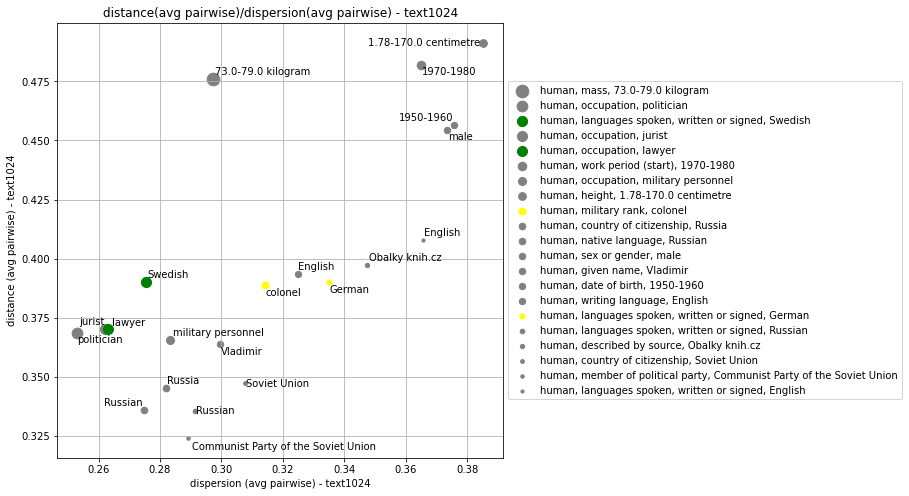

In [147]:
disp_col = f"dispersion (avg pairwise) - {emb_model_name}"
dist_col = f"distance (avg pairwise) - {emb_model_name}"
size_col = f"distance(avg pairwise)/dispersion(avg pairwise) - {emb_model_name}"
plot_surprise_metrics(ent_to_facts_df[ent], disp_col, dist_col, "plab_label", size_col, "surprise_label")


## Visualizing some embeddings and looking into weird result - this could be useful for analysis...

**Why is the mass sample for putin so compact???**  
Let's look at some of the entities who have this...

In [318]:
mass_sample = list(get_entities_with_profile_label("Q5_P2067_73.0-79.0__Q11570", limit=1000, label_to_ents_dict=human_label_to_ents_dict))
mass_sample_embeds = [embedding_models["text"][ent] for ent in mass_sample]
mass_sample_centroid = np.mean(mass_sample_embeds, axis=0)
dists = [distance.cosine(mass_sample_centroid, e) for e in mass_sample_embeds]

Results was that all entities near centroid are soccer players. Soccer players are more likley to have mass filled out than other humans.

### Looking at entity vs sample for specific profile labels

In [333]:
ent = "Q7747"
ent_embed = embedding_models["text"][ent]
# label_id = "Q5_P410_Q104680"  # military rank colonel 
# label_id = "Q5_P106_Q40348"  # lawyer
# label_id = "Q5_P2048_1.78-170.0__Q174728"  # height
label_id = "Q5_P2067_73.0-79.0__Q11570" # mass
# label_id = "Q5_P1412_Q9027"  # languages = sweden
ents_sharing_label = get_entities_with_profile_label(label_id, ent, 10000, human_label_to_ents_dict)
sample_embeds = np.array([embedding_models["text"][e] for e in ents_sharing_label if e in embedding_models["text"]])
centroid = np.mean(sample_embeds, axis=0)

# Set up a logs directory, so Tensorboard knows where to look for files.
log_dir=f'{output_dir}/logs/putin_mass/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Save Labels separately on a line-by-line manner.
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
    for sample_ent in ents_sharing_label:
        if sample_ent not in embedding_models["text"]:
            continue
        f.write(f"{sample_ent} ({labels_en_dict[sample_ent]})\n")
    f.write(f"sample centroid\n")
    f.write(f"{ent} ({labels_en_dict[ent]})\n")

# Save the weights we want to analyze as a variable.
weights = tf.Variable(np.vstack([sample_embeds,centroid,ent_embed]))
# Create a checkpoint from embedding, the filename and key are the
# name of the tensor.
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

# Set up config.
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`.
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

Putin -- military rank

In [288]:
%tensorboard --logdir {log_dir} --port 6008

Reusing TensorBoard on port 6008 (pid 36417), started 1:27:49 ago. (Use '!kill 36417' to kill it.)

Putin -- Mass

In [337]:
%tensorboard --logdir {log_dir} --port 6009

Reusing TensorBoard on port 6009 (pid 48849), started 0:14:57 ago. (Use '!kill 48849' to kill it.)

Putin -- height

In [292]:
%tensorboard --logdir {log_dir} --port 6010

Reusing TensorBoard on port 6010 (pid 36008), started 1:35:25 ago. (Use '!kill 36008' to kill it.)

languages = swedish

In [261]:
%tensorboard --logdir {log_dir} --port 6012

Reusing TensorBoard on port 6012 (pid 35326), started 0:03:49 ago. (Use '!kill 35326' to kill it.)

## Try computing suprise(fact2 | fact1)

In [ ]:
def compute_label_dists_and_disps(labels_list, embedding_dict, 
                                  label_to_ents_dict, sample=10000, pairwise_sample=10000):
    label_to_sample = {}
    for l in labels_list:
        sample_ents = get_entities_with_profile_label(l, limit=sample, label_to_ents_dict=label_to_ents_dict)
        sample_embeds = np.array([embedding_dict[e] for e in sample_ents])
        label_to_sample[l] = sample_embeds

    disps = {}
    for l, sample_embeds in label_to_sample.items():
        # avg pairwise dist within sample
        sample_dists = []
        for i in range(pairwise_sample):
            e1, e2 = sample_embeds[np.random.choice(sample_embeds.shape[0], size=2, replace=False), :]
            sample_dists.append(distance.cosine(e1, e2))
        avg_sample_to_sample = np.mean(sample_dists)
        disps[l] = avg_sample_to_sample
        
    dists = {}
    for l1, sample_embeds1 in label_to_sample.items():
        for l2, sample_embeds2 in label_to_sample.items():
            # skip if labels are same
            if l1==l2:
                continue
            # init first level of dictionary
            if l1 not in dists:
                dists[l1] = {}
            if l2 not in dists:
                dists[l2] = {}
            # we may have already computed this. If we have, then l2 will be in l1's dict and vice versa
            if l2 not in dists[l1]:
                TODO
                
                
                       

### Putin again

In [268]:
ent="Q7747"
labels_list = list(ent_to_profile_labels_df[ent]["id"])

In [270]:
label_dists, label_disps = compute_label_dists_and_disps(labels_list, embedding_models["text"], 
                                                         human_label_to_ents_dict, sample=10000, pairwise_sample=10000)


,id,plab_label,support,distinctiveness,surprise_label,dispersion (centroid) -- text,distance (centroid) -- text,distance (avg pairwise) -- text,dispersion (avg pairwise) -- text,distance(centroid)/dispersion(centroid) -- text,distance(avg pairwise)/dispersion(centroid) -- text,distance(avg pairwise)/dispersion(avg pairwise) -- text
368140,Q5_P21_Q6581097,"human, sex or gender, male",0.5779681838190067,0.175249,0,0.459792,0.878898,0.934537,0.708789,1.911513,2.032521,1.318497
368143,Q5_P106_Q82955,"human, occupation, politician",0.06521513442634484,0.197663,0,0.295231,0.667556,0.764844,0.505178,2.261131,2.590662,1.514009
368151,Q5_P1412_Q1860,"human, languages spoken, written or signed, En...",0.025629212807962157,0.263496,0,0.430575,0.664019,0.806316,0.678580,1.542166,1.872649,1.188240
368154,Q5_P1412_Q188,"human, languages spoken, written or signed, Ge...",0.019660259037766203,0.354203,1,0.410927,0.644577,0.788738,0.653401,1.568593,1.919412,1.207127
368181,Q5_P106_Q40348,"human, occupation, lawyer",0.008697859135084906,0.243468,2,0.311993,0.660482,0.765957,0.527901,2.116978,2.455045,1.450949
368186,Q5_P27_Q15180,"human, country of citizenship, Soviet Union",0.007849251764756461,0.416726,0,0.371929,0.541399,0.709657,0.603842,1.455652,1.908048,1.175237
368191,Q5_P106_Q47064,"human, occupation, military personnel",0.0069975909712475005,0.243525,0,0.331771,0.608185,0.736354,0.554334,1.833146,2.219461,1.328358
368194,Q5_P27_Q159,"human, country of citizenship, Russia",0.0068761868655902655,0.392806,0,0.304808,0.545132,0.682417,0.515531,1.788446,2.238844,1.323717
368211,Q5_P1343_Q67311526,"human, described by source, Obalky knih.cz",0.005793687279634449,0.228881,0,0.434292,0.677824,0.814774,0.680180,1.560758,1.876098,1.197880
368260,Q5_P1412_Q7737,"human, languages spoken, written or signed, Ru...",0.003758763935212711,0.414013,0,0.364229,0.523397,0.694026,0.596603,1.437002,1.905467,1.163296


## FunFacts data from wikipedia mapped to WD

In [243]:
funfacts_df = pd.read_csv("/data02/profiling/FunFacts/experiment_results/evaluation_study/funfacts_mapped_to_wd.tsv", sep='\t').fillna("")


In [244]:
funfacts_df

,Input.Article,Article.wd,Input.Fact,fact.wd,Input.Type,in WD?,likely in profiles?,goodTrivia,knew,surprising
0,A. P. J. Abdul Kalam,Q9513,A. P. J. Abdul Kalam is in the group of Indian...,"P27=Q668,P106=Q10497074",ourMiddle,1.0,1.0,0.00,-2.0,0.4
1,A. P. J. Abdul Kalam,Q9513,A. P. J. Abdul Kalam is in the group of Nuclea...,,ourTop,0.0,0.0,-0.20,-2.0,-0.2
2,A. P. J. Abdul Kalam,Q9513,A. P. J. Abdul Kalam is in the group of Recipi...,P166=Q932650,ourBottom,1.0,0.0,-0.60,-2.0,-0.6
3,A. P. J. Abdul Kalam,Q9513,"On 10 June 2002, the National Democratic Allia...",,baseline,0.0,0.0,-0.40,-2.0,-0.2
4,Abraham Lincoln,Q91,Abraham Lincoln is in the group of Presidents ...,,ourBottom,1.0,0.0,-1.80,1.2,-1.8
...,...,...,...,...,...,...,...,...,...,...
357,Winston Churchill,Q8016,Winston Churchill is in the group of British m...,,ourTop,,,-0.60,-2.0,-0.2
358,Winston Churchill,Q8016,Winston Churchill is in the group of UK MPs 19...,,ourMiddle,,,-0.40,-1.2,-0.2
359,Zlatan IbrahimoviÄ‡,Q46896,"On 27 November 2013, Ibrahimović made his 100t...",,baseline,,,-0.25,-1.2,0.0
360,Zlatan IbrahimoviÄ‡,Q46896,Zlatan IbrahimoviÄ‡ is in the group of Expatri...,,ourMiddle,,,-0.60,-1.2,-0.6


In [249]:
mask = [fact != "" and '_' not in fact for fact in funfacts_df.loc[:,"fact.wd"]]
masked_ff_df=funfacts_df.loc[mask]

In [250]:
with pd.option_context("max_colwidth",None):
    display(masked_ff_df)

,Input.Article,Article.wd,Input.Fact,fact.wd,Input.Type,in WD?,likely in profiles?,goodTrivia,knew,surprising
0,A. P. J. Abdul Kalam,Q9513,A. P. J. Abdul Kalam is in the group of Indian aerospace engineers,"P27=Q668,P106=Q10497074",ourMiddle,1.0,1.0,0.00,-2.0,0.4
2,A. P. J. Abdul Kalam,Q9513,A. P. J. Abdul Kalam is in the group of Recipients of the Padma Vibhushan,P166=Q932650,ourBottom,1.0,0.0,-0.60,-2.0,-0.6
7,Akshay Kumar,Q233748,Akshay Kumar is in the group of Canadian game show hosts,"P27=Q16,P106=Q22662561",ourTop,0.0,0.0,-0.60,-2.0,-0.4
8,Akshay Kumar,Q233748,Akshay Kumar is in the group of Indian stunt performers,"P27=Q668,P106=Q465501",ourMiddle,0.0,0.0,-0.60,-2.0,-0.6
10,Alan Rickman,Q106481,Alan Rickman is in the group of 20th-century English male actors,"cent20,P27=Q145,P21=Q6581097,P106=Q33999",ourMiddle,1.0,2.0,-1.40,2.0,-1.6
12,Alan Rickman,Q106481,Alan Rickman is in the group of English male voice actors,"P27=Q145,P21=Q6581097,P106=Q2405480",ourBottom,1.0,1.0,-1.20,1.2,-1.2
14,Albert Einstein,Q937,Albert Einstein is in the group of 20th-century physicists,"cent20,P106=Q169470",ourBottom,1.0,0.0,-1.40,2.0,-2.0
15,Albert Einstein,Q937,Albert Einstein is in the group of American Zionists,"P27=P30,P106=Q12718299",ourTop,0.0,0.0,0.25,-0.4,0.4
18,Alec Baldwin,Q170572,Alec Baldwin is in the group of 20th-century American male actors,"cent20,P27=Q30,P21=Q6581097,P106=Q33999",ourBottom,1.0,2.0,-1.80,2.0,-1.8
24,Alicia Vikander,Q439314,"Alicia Amanda Vikander (born 3 October 1988) is a Swedish actress, producer and dancer.","P27=Q34,P21=Q6581072,P106=Q33999,P106=Q3282637,P106=Q5716684",baseline,1.0,1.0,-0.80,-1.2,-0.8


In [251]:
def get_fact_ids_from_str(fact_strs):
    fact_ids = []
    for fact_str in fact_strs.split(','):
        if "cent" in fact_str:
            # TODO - handle century fact here
            continue
        else:
            fact_ids.append("Q5_" + '_'.join(fact_str.split('=')))
    return fact_ids

count_rows_w_facts_in_profiles = 0
count_rows_w_facts_in_profiles_and_entity_has_them = 0
for ent, fact_strs in zip(masked_ff_df.loc[:,"Article.wd"], masked_ff_df.loc[:,"fact.wd"]):
    fact_ids = get_fact_ids_from_str(fact_strs)
    if sum([f in label_to_ents_dict for f in fact_ids]) == len(fact_ids):
        count_rows_w_facts_in_profiles += 1
        if sum([f in ent_to_labels_dict[ent] for f in fact_ids]) == len(fact_ids):
             count_rows_w_facts_in_profiles_and_entity_has_them += 1
    
print(f"count_rows_w_facts_in_profiles: {count_rows_w_facts_in_profiles}")
print(f"count_rows_w_facts_in_profiles_and_entity_has_them: {count_rows_w_facts_in_profiles_and_entity_has_them}")

count_rows_w_facts_in_profiles: 32
count_rows_w_facts_in_profiles_and_entity_has_them: 27


In [253]:
sum(["|" in f for f in masked_ff_df.loc[:,"fact.wd"]])

3